# Lonlat ms diagnosis on main combination

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms



import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

import histlib.matchup as match
import histlib.diagnosis as diag
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part, global_drifter_sat
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
dl=5
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

var = list(id_co_dic.values())+list(id_aviso_dic.values())+['nb_coloc_bin']+['sum_'+v for v in [id_aviso, id_co]]+['sum_'+v for v in [id_aviso, id_co]]+['exc_acc_'+v for v in [id_aviso, id_co]]+['exc_coriolis_'+v for v in [id_aviso, id_co]]+['exc_ggrad_'+v for v in [id_aviso, id_co]]+['exc_wind_'+v for v in [id_aviso, id_co]]

# Datasets 

In [3]:
files_ms = glob(os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files_ms = [f for f in files_ms if 'gps' in f]
files_mean = glob(os.path.join(zarr_dir+'_ok',f'meanlonlat/meanlonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files_mean = [f for f in files_mean if 'gps' in f]
files_corr = glob(os.path.join(zarr_dir+'_ok',f'corrlonlat/corrlonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files_corr = [f for f in files_corr if 'gps' in f]

In [4]:
dsms = xr.open_mfdataset(files_ms)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dsmean = xr.open_mfdataset(files_mean)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dscorr = xr.open_mfdataset(files_corr).rename({'nb_coloc_bin':'nb_coloc'}).compute()

In [5]:
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' (latbin: 36, lonbin: 72)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  3., 12., ...,  8.,  0., 13.],
       ...,
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latbin   (latbin) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lonbin   (lonbin) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5


In [6]:
dsc = -2 * global_drifter_sat(dscorr)# balanced contribution
dsc['nb_coloc'] = -dsc['nb_coloc']/2
dsc

<xarray.DataArray 'nb_coloc' (latbin: 36, lonbin: 72)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  3., 12., ...,  8.,  0., 13.],
       ...,
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latbin   (latbin) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lonbin   (lonbin) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5


<xarray.Dataset>
Dimensions:                                                                              (
                                                                                          latbin: 36,
                                                                                          lonbin: 72)
Coordinates:
  * latbin                                                                               (latbin) float64 ...
  * lonbin                                                                               (lonbin) float64 ...
Data variables: (12/45)
    prod_alti_ggx_adt_filtered__es_cstrio_z15_alti_wd_x                                  (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered__es_cstrio_z15_drifter_wd_x                               (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide__es_cstrio_z15_alti_wd_x                       (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide__es_cstrio_z15_drifter_wd_x                    (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide_internal_tide__es_cstrio_z15_alti_wd_x         (latbin, lonbin) float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide_internal_tide__es_cstrio_z15_drifter_wd_x      (latbin, lonbin) float64 ...
    ...                                                                                   ...
    prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide_dac       (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__aviso_alti_ggx_adt                                       (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__aviso_drifter_ggx_adt                                    (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__es_cstrio_z15_alti_wd_x                                  (latbin, lonbin) float64 ...
    prod_drifter_coriolis_x_25__es_cstrio_z15_drifter_wd_x                               (latbin, lonbin) float64 ...
    nb_coloc                                                                             (latbin, lonbin) float64 ...

______________________
# Fig function

In [7]:
def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

def plot_total_lonlat_hist(var, ax, bins=30) :
    v = var.values.ravel()
    v = v[~np.isnan(v)]
    hist, bedge = np.histogram(v, bins=bins)
    ax.plot(bedge[:-1] + (bedge[1]-bedge[0])/2, hist)

def plot_lonlat(var,ax, letter=None, retins=False, **kwargs):
    dkwargs = dict(cmap='viridis')
    dkwargs.update(kwargs)
    var.plot(ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    if letter : 
        put_fig_letter(ax, letter)
    ins = ax.inset_axes(ins_ax_box)
    plot_total_lonlat_hist(var, ins)
    ins.grid()
    ins.set_yticks([])
    ins.set_xlabel('')
    bbox = dict(ec="w", fc="w", alpha=0.8)
    plt.setp(ins.get_xticklabels(), bbox=bbox)
    ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')
    ins.xaxis.get_offset_text().set(bbox=bbox)
    if retins:
        return ins

## Inserted box
#ins_ax_box = [0.66,0.73,0.25,0.27]
ins_ax_box = [0.56,0.7,0.29,0.3]

_________
# Compute all 

In [8]:
###### Residual and Total error ratio S and nS ######
test = mserr['sum_'+id_co]/ds['sum_'+id_co]*100<50 # keep only bins where S relative error is below 50%
#test2 = mserr['sum_'+id_aviso]/ds['sum_'+id_aviso]*100<50
#test=test1 & test2
dsm = ds.where(test)
dse=mserr.where(test)

def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
    
sco = compute_sum_ms(dsm, id_co, id_co_dic).assign_attrs({'long_name':'$\Sigma$', 'units':r'$m^2.s^{-4}$'})
saviso = compute_sum_ms(dsm, id_aviso, id_aviso_dic)

###### Balanced/unbalanced part ######
def true_err_x(ds, id_, dic) :
    dso = xr.Dataset()
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dsmss = xr.concat([true_err_x(dsm, id_co, id_co_dic), true_err_x(dsm, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
for v in ['acc', 'coriolis', 'ggrad', 'wind']: 
    dsmss['true_' + v].attrs ={'long_name':r'Balanced physical signal', 'unit':r'$m^2/s^4$'}
    dsmss['err_' + v].attrs ={'long_name':r'Error signal', 'unit':r'$m^2/s^4$'}
dsmss['nb_coloc']=dsm['nb_coloc']
## normalized
dsmssco = dsmss.sel(id_comb =id_co)
s = compute_sum_ms(dsm, id_co, id_co_dic)
dsmssco_s = dsmssco/s*100

###### Pairs contributions  ######

import itertools
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]
dsc_ = dsc.where(test)

#normalized
dsm['sigma_co']=compute_sum_ms(dsm, id_co, id_co_dic)
dscn = dsc_/dsm['sigma_co']*100
dscn['nb_coloc'] = dsc_['nb_coloc']

_________
# Select areas

In [9]:
# Gulf Stream 
area_geo = dscn[corr_var_co[3]]>70
gulf_stream = area_geo.where(area_geo.lonbin<0, False).where(area_geo.latbin>15, False).where(area_geo.lonbin>-85, False).where(area_geo.latbin<50, False)
# ACC 
testlat = (dscn.latbin<-35)
area_geo = dscn[corr_var_co[3]]>45
acc = area_geo.where(testlat, False)
# North Pacific
area_geo = dscn[corr_var_co[0]]>10
testlon = (dscn.lonbin<-120)| (dscn.lonbin>150)
testlat = (dscn.latbin>40)
north_pacific = area_geo.where(testlat & testlon, False)
# Tropics
testlat = (dscn.latbin<15)&(dscn.latbin>-15)
tropics = dscn[corr_var_co[3]].where(testlat, False)

areas = {'Gulf Stream':gulf_stream, 'ACC':acc, 'North Pacific':north_pacific, 'EQ':tropics}
color_areas = {'Gulf Stream':'red', 'ACC':'darkorange', 'North Pacific':'magenta', 'EQ':'salmon'}
def plot_areas(ax, lw=1.5):
    # Gulf Stream
    gulf_stream.plot.contour(ax=ax, levels=1, colors=[color_areas['Gulf Stream']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('GS', (-90, 35), zorder=6, c=color_areas['Gulf Stream'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #ACC
    acc.plot.contour(ax=ax, levels=1, colors=[color_areas['ACC']], linewidths=lw,transform=ccrs.PlateCarree())
    ax.annotate('ACC', (-120, -83), zorder=6, c=color_areas['ACC'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #Equator
    ax.axhline(-15, lw=lw, c=color_areas['North Pacific'])
    ax.axhline(15, lw=lw, c=color_areas['North Pacific'])
    ax.annotate('EQ', (10, 0), zorder=6, c=color_areas['North Pacific'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    # North_pacific
    north_pacific.plot.contour(ax=ax, levels=1, colors=[color_areas['EQ']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('NP', (-160, 64), zorder=6, c=color_areas['EQ'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))

In [ ]:
## Numbers of coloc per areas

In [ ]:
dsmss.where(areas['ACC']).nb_coloc.sum()

In [ ]:
for a in areas : 
    print(a,dsmss.where(areas[a]).nb_coloc.sum())

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(7,4))
title = ['Coriolis - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - wind term',]


label = r"Normalized pair's contribution $X_{ij}/\Sigma$"

plot_areas(ax)

ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False

#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Distribution of colocalization per bins

In [ ]:
min_coloc_bin = 30
ds['nb_coloc'].attrs = {'long_name': 'Number of colocations per bin'}

In [ ]:
fig = plt.figure(figsize=(14,5), frameon=False)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ds.where(ds.nb_coloc> 0).nb_coloc.plot(x='lonbin', y='latbin', cmap='viridis', levels=[min_coloc_bin]+list(np.arange(100, 1100, 100)), ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=1, linestyle=':', zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False

ins = ax.inset_axes(ins_ax_box)
plot_total_lonlat_hist(ds.where(ds.nb_coloc> 0).nb_coloc, ins)
bbox = dict(ec="w", fc="w", alpha=0.8)
plt.setp(ins.get_xticklabels(), bbox=bbox)



ins.grid()
ins.set_yticks([])
ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')

fig.savefig('images/lonlat_distrib.png',bbox_inches='tight',   dpi=300)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax=axs[0]
ds.where(ds.nb_coloc> 0).nb_coloc.mean('lonbin').plot(ax=ax, c='teal')
ax.set_xlabel('Latitude [°]')
ax.set_ylabel('Mean number of \n colocations per bin [°]')
ax.grid()
put_fig_letter(ax, 'a')

ax =axs[1]
dd = 10
_ds = ds.where(ds.nb_coloc> min_coloc_bin).nb_coloc
hist = _ds.plot.hist(bins=np.arange(30,4000, 50), ax=ax, color='teal')
mean = _ds.mean().values
q90 = _ds.quantile(0.9).values
q10 = _ds.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_xlim(0, 1000)
put_fig_letter(ax, 'b')

fig.savefig('images/lonlat_coloc_hist.png',  bbox_inches='tight',  dpi=300)

______________________
# Closure efficiancy : S and nS

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
dsm['sum_'+id_co].mean(dim='lonbin').plot(ax=ax, label='S')
dsm['drifter_coriolis_x_25'].mean(dim='lonbin').plot(ax=ax)
dsm['drifter_acc_x_25'].mean(dim='lonbin').plot(ax=ax)
dsm['alti_ggx_adt_filtered_ocean_tide_internal_tide'].mean(dim='lonbin').plot(ax=ax)
sco.mean(dim='lonbin').plot(ax=ax, label='SCO')
ax.legend()
ax.grid()

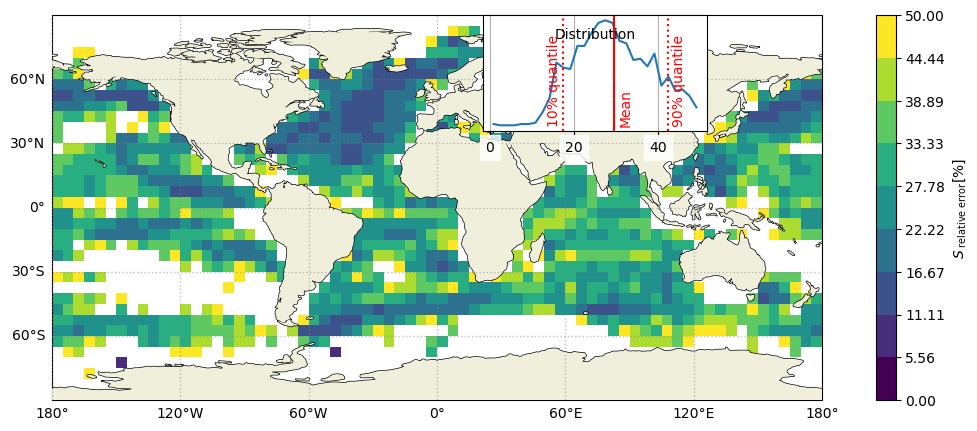

In [96]:
dse=mserr.where(test)
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dse['sum_'+id_co]/dsm['sum_'+id_co]*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
ins = plot_lonlat(ne, ax,'', levels=10,vmax=50, retins=True)

#mean, quartile
ne_ = ne.values.ravel()
ne_ = ne_[~np.isnan(ne_)]
ins.axvline(ne_.mean(), c='r')
ins.annotate('Mean',(ne_.mean()+1, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 10), ls=':', c='r')
ins.annotate('10% quantile',(np.percentile(ne_, 10)-4, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 90), ls=':', c='r')
ins.annotate('90% quantile',(np.percentile(ne_, 90)+1, 1), color='r', rotation=90)
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.set_title('Along-track')
fig.savefig('images_all/lonlat_msre_err_alg.png', bbox_inches='tight', dpi=300)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
(dsm['sum_'+id_co]).mean(dim='lonbin').plot(ax=ax, label='nS', color='teal')
ax.set_xlabel('Latitude [degree]')
ax.set_ylabel(r'Residual MS $S$ [$m^2.s^{-4}$]')
ax.tick_params(axis='y', labelcolor='teal')
ax.grid(axis='y',color='teal', ls=':')
ax.grid(axis='x', ls=':')
ax2 = ax.twinx()
(dsm['sum_'+id_co]/sco*100).mean(dim='lonbin').plot(ax=ax2, label='nS', color='r')
ax2.set_xlabel('Latitude [degree]')
ax2.set_ylabel(r'Total error ratio $nS$ [%]')
ax2.tick_params(axis='y', labelcolor='r')
ax2.grid(axis='y',color='r',ls=':')
fig.savefig('images/lonlat_lat_hist_msre_nmsre_alg.png', bbox_inches='tight',   dpi=300)

In [ ]:
plt.scatter(dsm['sum_'+id_co], sco, c=np.array(np.abs(np.repeat(dsm.latbin, len(dsm.lonbin)))), s=2)
plt.grid()
plt.xlabel('S')
plt.ylabel(r'$\Sigma$')

In [ ]:
plt.scatter(dsm['sum_'+id_co], dsm['sum_'+id_co]/sco, c=np.array(np.abs(np.repeat(dsm.latbin, len(dsm.lonbin)))), s=2)
plt.grid()
plt.xlabel('S')
plt.ylabel('nS')

In [ ]:
# CO 
fig, axs = plt.subplots(2,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,8), frameon=False)
ax = axs[0]
dsm['sum_'+id_co].attrs = {'long_name':r'Residual MS $S$ $[m^2/s^4]$'}
ins = plot_lonlat(dsm['sum_'+id_co],ax, 'a', vmax = 3e-10, levels=10, retins=True)
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[2e-10], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(2e-10, color = 'r')
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[7e-11], colors=['orange'], transform=ccrs.PlateCarree())
#ins.axvline(7e-11, color = 'orange')

ax = axs[1]
nmsre = (dsm['sum_'+id_co]/sco*100).assign_attrs({'long_name': r'Total error ratio $nS$ [%]'})
plot_lonlat(nmsre,ax, 'b', levels=10)
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[2e-10], colors=['red'])


for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])
fig.savefig('images/lonlat_msre_nmsre_alg.png', bbox_inches='tight',   dpi=300)


## S Alone
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
dsm['sum_'+id_co].attrs = {'long_name':r'Residual MS $S$ $[m^2/s^4]$'}
ins = plot_lonlat(dsm['sum_'+id_co],ax, '', vmax = 3e-10, levels=10, retins=True)
#dsm['sum_'+id_aviso].plot.contour(ax=ax, levels=[2e-10], colors=['red'])
ins.axvline(1.6e-10, color = 'r', ls=':')
ins.annotate('Global mean',( 2e-10, 5), color='r', rotation=90)

plot_areas(ax)

ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=3)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#fig.suptitle('AVISO')
fig.tight_layout(rect=[0,0,1,1])
fig.savefig('images/lonlat_msre_alg.png', bbox_inches='tight',   dpi=300)

# AVISO
fig, axs = plt.subplots(2,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,8), sharex=True, sharey=True, frameon=False)
ax = axs[0]
dsm['sum_'+id_aviso].attrs = {'long_name':r'Residual MS $S$ $[m^2/s^4]$'}
ins = plot_lonlat(dsm['sum_'+id_aviso],ax, 'a', vmax = 3e-10, levels=10, retins=True)
#dsm['sum_'+id_aviso].plot.contour(ax=ax, levels=[2e-10], colors=['red'])
#ins.axvline(2e-10, color = 'r')

ax = axs[1]
nmsre = (dsm['sum_'+id_aviso]/saviso*100).assign_attrs({'long_name': r'Total error ratio $nS$ [%]'})
plot_lonlat(nmsre,ax, 'b', levels=10)
#dsm['sum_'+id_aviso].plot.contour(ax=ax, levels=[2e-10], colors=['red'])

for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=3)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle('AVISO')
fig.tight_layout(rect=[0,0,1,1])
fig.savefig('images/lonlat_msre_nmsre_aviso.png', bbox_inches='tight',   dpi=300)

## Sum of individual term MSs $\Sigma$

In [ ]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[2e-10], colors=['red'], transform=ccrs.PlateCarree())
plot_lonlat(sco,ax, levels=10, norm=colors.LogNorm(vmin=sco.min(), vmax=sco.max()))
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[7e-11], colors=['orange'], transform=ccrs.PlateCarree())
#ins.axvline(7e-11, color = 'orange')
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])
fig.savefig('images/lonlat_sco_alg.png', bbox_inches='tight',   dpi=300)


## Relative error on S

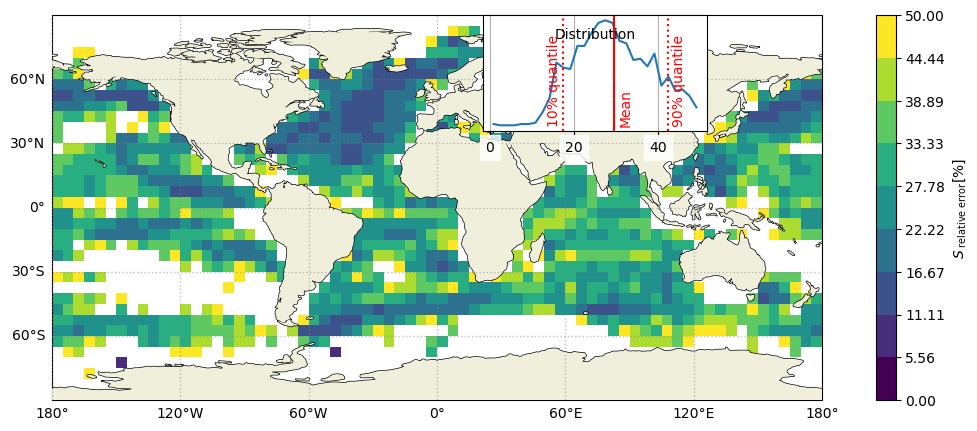

In [96]:
dse=mserr.where(test)
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dse['sum_'+id_co]/dsm['sum_'+id_co]*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
ins = plot_lonlat(ne, ax,'', levels=10,vmax=50, retins=True)

#mean, quartile
ne_ = ne.values.ravel()
ne_ = ne_[~np.isnan(ne_)]
ins.axvline(ne_.mean(), c='r')
ins.annotate('Mean',(ne_.mean()+1, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 10), ls=':', c='r')
ins.annotate('10% quantile',(np.percentile(ne_, 10)-4, 1), color='r', rotation=90)
ins.axvline(np.percentile(ne_, 90), ls=':', c='r')
ins.annotate('90% quantile',(np.percentile(ne_, 90)+1, 1), color='r', rotation=90)
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.set_title('Along-track')
fig.savefig('images_all/lonlat_msre_err_alg.png', bbox_inches='tight', dpi=300)


In [ ]:
dse=mserr.where(test)
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dse['sum_'+id_co]/dsm['sum_'+id_co]*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
plot_lonlat(ne, ax,'', levels=10)
ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.set_title('Along-track')
fig.savefig('images/lonlat_msre_err_alg.png', bbox_inches='tight', dpi=300)


In [ ]:
dse=mserr.where(test)
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,5), frameon=False)
ne = (dse['sum_'+id_aviso]/dsm['sum_'+id_aviso]*100).assign_attrs({'long_name':r'$S_{\text{ relative error}}$[%]'})
ne.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax = 50)
ins = ax.inset_axes(ins_ax_box)
plot_total_lonlat_hist(ne, ins)
ins.grid()
ins.set_yticks([])
ins.set_xlabel('')
ins.xaxis.set_ticks_position('top')

ax.add_feature(cfeature.LAND, zorder=5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title('AVISO')

In [ ]:
dd = 10
_ds = ds.where(ds.nb_coloc >0).nb_coloc
fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = ne.plot.hist(bins=np.arange(0,70, 1), ax=ax, color='teal')
mean = ne.mean().values
q90 = ne.quantile(0.9).values
q10 = ne.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 300))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 100))
ax.annotate(f'QMean% = {int(mean)}',(mean+dd, 200))
ax.grid()
ax.set_title('Along-track')

______________________
# Pairs contribution


In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis acceleration - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
dsc_[corr_var_co[3]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[3]], ax, 'a', vmin = 0, vmax=2e-9,)
plot_areas(ax)
ax.set_title(title[0])

ax=axs[1]
dsc_[corr_var_co[0]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[0]], ax, 'b', vmin = 0, vmax=6e-10,)
plot_areas(ax)
ax.set_title(title[1])

ax=axs[2]
dsc_[corr_var_co[1]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[1]], ax, 'c', vmin = 0, vmax = 2e-10,)
plot_areas(ax)
ax.set_title(title[2])

ax=axs[3]
dsc_[corr_var_co[4]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[4]], ax, 'c', vmin = 0, vmax = 2e-10,)
plot_areas(ax)
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_pair_alg.png', bbox_inches='tight',   dpi=300)


In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,3.5), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Inertial acceleration - Wind term']
axs=axs.flatten()

label = r"Pair's contribution $X_{ij}$"
ax=axs[0]
dsc_[corr_var_co[5]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[5]], ax, 'a',vmin = -1e-10, vmax = 1e-10,)
ax.set_title(title[0])

ax=axs[1]
dsc_[corr_var_co[2]].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsc_[corr_var_co[2]], ax, 'b',vmin = -2e-11, vmax =2e-11,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_other_pair_alg.png', bbox_inches='tight',   dpi=300)


## Contribution normalized by $\Sigma$

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), sharex=True, sharey=True, frameon=False)
title = ['Coriolis - Pressure gradient', 'Inertial acceleration - Coriolis acceleration', 'Inertial acceleration - Pressure gradient','Coriolis acceleration - Wind term',]
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
dscn[corr_var_co[3]].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(dscn[corr_var_co[3]], ax, 'a', vmin = 0, retins=True)
plot_areas(ax)
#dscn[corr_var_co[3]].plot.contour(ax=ax, levels=[70], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(70, color = 'r')
ax.set_title(title[0])

ax=axs[1]
dscn[corr_var_co[0]].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(dscn[corr_var_co[0]], ax, 'b', vmin = 0, vmax=60, retins=True)
plot_areas(ax)
#dscn[corr_var_co[0]].plot.contour(ax=ax, levels=[60], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(60, color = 'r')
ax.set_title(title[1])


ax=axs[2]
dscn[corr_var_co[1]].attrs={'long_name':label, 'unit':'%'}
ins= plot_lonlat(dscn[corr_var_co[1]], ax, 'c', vmin = 0, vmax=50, retins=True)
#dscn[corr_var_co[1]].plot.contour(ax=ax, levels=[25], colors=['red'], transform=ccrs.PlateCarree())
plot_areas(ax)
#acc.plot.contour(ax=ax, levels=1, colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(30, color = 'r')
ax.set_title(title[2])

ax=axs[3]
dscn[corr_var_co[4]].attrs={'long_name':label, 'unit':'%'}
ins = plot_lonlat(dscn[corr_var_co[4]], ax, 'c', vmin = 0, vmax=25, retins=True)
plot_areas(ax)
#dscn[corr_var_co[4]].plot.contour(ax=ax, levels=[10], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(10, color = 'r')
ax.set_title(title[3])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_pair_normalized_alg.png',  bbox_inches='tight',  dpi=300)

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,4), sharex=True, sharey=True, frameon=False)
title = ['Pressure gradient - Wind term','Inertial acceleration- Wind term']
axs=axs.flatten()

label = r"Normalized pair's contribution $X_{ij}/\Sigma$"
ax=axs[0]
dscn[corr_var_co[5]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[5]], ax, 'a',vmin = -5, vmax = 5,)
ax.set_title(title[0])

ax=axs[1]
dscn[corr_var_co[2]].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dscn[corr_var_co[2]], ax, 'b',vmin = -3, vmax = 3,)
ax.set_title(title[1])

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Along-track")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_other_pair_normalized_alg.png', bbox_inches='tight',   dpi=300)

________________________
# Balanced/errors parts

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Balanced physical part rms'

ax=axs[0]
dsmssco['true_acc'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(dsmssco['true_acc']), ax, 'a', vmin = 0, vmax=2e-5)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco['true_coriolis'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(dsmssco['true_coriolis']), ax, 'b', vmin = 0, vmax=3e-5)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco['true_ggrad'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(dsmssco['true_ggrad']), ax, 'c', vmin = 0, vmax=3e-5,)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco['true_wind'].attrs={'long_name':label, 'unit':r'$m/s^2$'}
plot_lonlat(np.sqrt(dsmssco['true_wind']), ax, 'd', vmin = 0, vmax=1e-5,)
#ax.set_title('Wind term')
ax.set_title('Wind term')
for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_true_alg_rms.png', bbox_inches='tight', dpi=300)

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Balanced physical part'

ax=axs[0]
dsmssco['true_acc'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_acc'], ax, 'a', vmin = 0, vmax=2.5e-10,)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco['true_coriolis'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_coriolis'], ax, 'b', vmin = 0, vmax=9e-10,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco['true_ggrad'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_ggrad'], ax, 'c', vmin = 0, vmax=7e-10,)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco['true_wind'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['true_wind'], ax, 'd', vmin = 0, vmax=4.5e-11,)
#ax.set_title('Wind term')
ax.set_title('Wind term')
for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_true_alg.png', bbox_inches='tight', dpi=300)

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Error part'

ax=axs[0]
dsmssco['err_acc'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_acc'], ax, 'a', vmin = 0, vmax=5.5e-11,)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco['err_coriolis'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_coriolis'], ax, 'b', vmin = 0, vmax=1e-10,)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco['err_ggrad'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_ggrad'], ax, 'c', vmin = 0, vmax=1e-10,)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco['err_wind'].attrs={'long_name':label, 'unit':r'$m^2/s^4$'}
plot_lonlat(dsmssco['err_wind'], ax, 'd', vmin = 0, vmax=2e-11,)
#ax.set_title('Wind term')
ax.set_title('Wind term')
for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_err_alg.png', bbox_inches='tight',   dpi=300)

## Check for colocalization mismatch errors 

In [ ]:
fig, ax = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True, frameon=False)

plot_lonlat((dsmssco['err_ggrad']-dsmssco['err_coriolis']), ax, 'a', vmin = -1e-10, vmax=1e-10, cmap='RdBu_r')
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title('Pressure gradient error - coriolis errors')

## Balanced/error part normalized by $\Sigma$

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Normalized captured physical part'

ax=axs[0]
dsmssco_s['true_acc'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_acc'], ax, 'a', vmin = 0, vmax=40)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco_s['true_coriolis'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_coriolis'], ax, 'b', vmin = 0, vmax=50)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco_s['true_ggrad'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_ggrad'], ax, 'c', vmin = 0, vmax=50)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco_s['true_wind'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['true_wind'], ax, 'd', vmin = 0, vmax=10)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_true_normalized_alg.png', bbox_inches='tight',   dpi=300)

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6), sharex=True, sharey=True, frameon=False)
axs=axs.flatten()
label = 'Normalized error part'

ax=axs[0]
dsmssco_s['err_acc'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_acc'], ax, 'a', vmin = 0, vmax=30)
ax.set_title('Inertial acceleration')

ax=axs[1]
dsmssco_s['err_coriolis'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_coriolis'], ax, 'b', vmin = 0, vmax=20)
ax.set_title('Coriolis acceleration')

ax=axs[2]
dsmssco_s['err_ggrad'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_ggrad'], ax, 'c', vmin = 0, vmax=30)
ax.set_title('Pressure gradient')

ax=axs[3]
dsmssco_s['err_wind'].attrs={'long_name':label, 'unit':'%'}
plot_lonlat(dsmssco_s['err_wind'], ax, 'd', vmin = 0, vmax=10)
#ax.set_title('Wind term')
ax.set_title('Wind term')

for ax in axs :# Draw the coastines for each subplot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle("Pairs' contributions")
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_err_normalized_alg.png', bbox_inches='tight',   dpi=300)

_________
# Diagnostics in areas

## Build dataset

In [ ]:
def mean_area(ds):
    ds_= (((ds*ds.nb_coloc).sum(['lonbin', 'latbin']))/(ds.nb_coloc.sum(['lonbin', 'latbin'])))
    for v in ds.keys():
        if v != 'nb_coloc':
            ds_[v].attrs=ds[v].attrs
    
    #nb_coloc
    nb_coloc = ds.nb_coloc.sum()
    ds_['nb_coloc']= nb_coloc
    
    return ds_

In [ ]:
dsmss_ = mean_area(dsmss.where(acc))
dsc_ = mean_area(dsc.where(acc))



## Synthetic figures

In [ ]:
def synthetic_figure(ds, dsc, dic, ax, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400
    
    ## INDIVIDUAL MS ##
    ax.barh(2*a, ds['acc'], color= c0['acc'], label = 'Inertial acceleration')
    ax.barh(2*a, ds['coriolis'], left =ds['acc']+b , color= c0['coriolis'], label = 'Coriolis acceleration')
    ax.barh(2*a, ds['ggrad'], left =ds['acc']+ds['coriolis']+2*b , color= c0['ggrad'], label = 'Pressure gradient term')
    ax.barh(2*a, ds['wind'], left =ds['acc']+ds['coriolis']+ds['ggrad']+3*b, color= c0['wind'], label = 'Wind term')
    

    ax.text(ts/2, 2*a+0.5, r'Individual MS $A_i$', ha='center') 
    #percentage + MS
    key = ['acc', 'coriolis', 'ggrad', 'wind']
    for i in range(len(key)) :
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center',bbox=bbox )
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a-0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
    
    #accolade
    c = 1e-12
    id1 =0
    id2 = ts + 3*b
    bx = [id1, id1, id2, id2]
    by = [3.70, 3.75, 3.75, 3.70]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(ts, 3.8, r'$\Sigma$', fontsize=15, ha='center')
    
    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    ax.barh(1*a, ds['true_acc'], color= c0['acc'])
    ax.barh(1*a, ds['err_acc'], left = ds['true_acc'], color= 'lightgrey', label='Errors')
    ax.barh(1*a, ds['true_coriolis'], left =ds['true_acc']+ds['err_acc']+b, color= c0['coriolis'])
    ax.barh(1*a, ds['err_coriolis'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis'], color= 'lightgrey')
    ax.barh(1*a, ds['true_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+b, color= c0['ggrad'])
    if ds['err_ggrad']>0 : 
        ax.barh(1*a, ds['err_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad'], color= 'lightgrey')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+ds['true_wind'], color= 'lightgrey')
    else : 
        print('ok')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+2*b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['true_wind']+2*b, color= 'lightgrey')
    
    ax.text(ts/2, 1*a+0.5, r'Balanced physical and errors parts MS $B_i$ and $E_i$', ha='center') 
    #percentage + MS
    key = ['true_acc','err_acc', 'true_coriolis','err_coriolis', 'true_ggrad','err_ggrad', 'true_wind', 'err_wind']
    for i in range(len(key)) :
        d=0
        dx=0
        if i==len(key)-1 : 
            d=-0.1*a 
            dx = 3e-11
        if i==len(key)-2 : d=0.1*a 
        if 'aviso' in dic['ggrad'] and i==len(key)-3 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2, a+d, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dx, a+d -0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b)

    tts = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b+ds['S']
    print(tts)
    sum_pairs = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    key = [vn(dic, 'coriolis', 'ggrad'),vn(dic, 'acc', 'coriolis'), vn(dic, 'acc', 'ggrad'), vn(dic, 'coriolis', 'wind')]
    for i in range(len(key)) :
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0, f'{int(np.rint((dsc[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0
        if 'aviso' in dic['ggrad'] and key[i]== vn(dic, 'acc', 'ggrad') : d = -0.1*a
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0-0.55+d, f'{np.format_float_scientific(dsc[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))} %', ha='center', bbox=bbox)
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    ax.set_xlim(-1e-11, xlim+1e-11)
    ax.set_ylim(-1, 4.1)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,-1),xytext=(0,-1),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

In [ ]:
for area in areas:
    print(area)
    dsmss_ = mean_area(dsmss.where(areas[area]))
    dsc_ = mean_area(dsc.where(areas[area]))
    plt.rcParams["axes.edgecolor"] = "w"
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False,)
    synthetic_figure(dsmss_.sel(id_comb=id_co), dsc_[corr_var_co+['nb_coloc']],id_co_dic, ax)#, xlim=2.5e-9) 
    fig.legend(ncol=5,loc='lower center')
    fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(area)
    fig.savefig(f"images/synth_alg{area.replace(' ','_')}.png",bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"

In [ ]:
handles, labels = ax.get_legend_handles_labels()

In [ ]:
plt.rcParams["axes.edgecolor"] = "k"

fig, axs = plt.subplots(2,2, sharey=True, figsize=(14,7))
dic = id_co_dic
def vn(id_dic, key1, key2):
    return 'prod_'+id_dic[key1]+'__'+id_dic[key2]

axs = axs.flatten()
i=0
for area in areas:
    
    print(area)
    dsmss_ = mean_area(dsmss.where(areas[area]))
    dsc_ = mean_area(dsc.where(areas[area]))
    ax=axs[i]
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.bar(0, dsc_[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.bar(1, dsc_[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.bar(2, dsc_[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(3, dsc_[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', capsize=10 )
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(4, dsc_[vn(dic, 'acc', 'wind')], color=c0['acc'], hatch='/', capsize=10 )
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(5, dsc_[vn(dic, 'ggrad', 'wind')], color=c0['ggrad'], hatch='/', capsize=10 )
    ax.grid()
    ax.set_ylim(-1e-10, 2.5e-9)
    ax.set_title(area)
    i+=1

In [ ]:
plt.rcParams["axes.edgecolor"] = "k"

fig, axs = plt.subplots(2,2, figsize=(14,7))
dic = id_co_dic
def vn(id_dic, key1, key2):
    return 'prod_'+id_dic[key1]+'__'+id_dic[key2]

axs = axs.flatten()
i=0
for area in areas:
    
    print(area)
    dsmss_ = mean_area(dsmss.where(areas[area]))
    dsc_ = mean_area(dsc.where(areas[area]))
    ax=axs[i]
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.bar(0, dsc_[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.bar(1, dsc_[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.bar(2, dsc_[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', capsize=10)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(3, dsc_[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', capsize=10 )
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(4, dsc_[vn(dic, 'acc', 'wind')], color=c0['acc'], hatch='/', capsize=10 )
    plt.rcParams['hatch.color'] = c0['wind']
    ax.bar(5, dsc_[vn(dic, 'ggrad', 'wind')], color=c0['ggrad'], hatch='/', capsize=10 )
    ax.grid()
    #ax.set_ylim(-1e-10, 2.5e-9)
    ax.set_title(area)
    i+=1

In [ ]:
def synthetic_figure_3lineonly(ds, dsc, dic, ax, xlim=None, pb_text=False) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400

    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b)

    tts = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b+ds['S']
    print(tts)
    sum_pairs = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    key = [vn(dic, 'coriolis', 'ggrad'),vn(dic, 'acc', 'coriolis'), vn(dic, 'acc', 'ggrad'), vn(dic, 'coriolis', 'wind')]
    for i in range(len(key)) :
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0, f'{int(np.rint((dsc[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0
        if 'aviso' in dic['ggrad'] and key[i]== vn(dic, 'acc', 'ggrad') : d = -0.1*a
        if pb_text and key[i]== vn(dic, 'acc', 'ggrad'):d=1.1
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0-0.6+d, f'{np.format_float_scientific(dsc[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))} %', ha='center', bbox=bbox)
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    #ax.set_xlim(-1e-11, xlim+1e-11)
    yax=-0.8
    ax.set_ylim(yax, 0.5)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,yax),xytext=(0, yax),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

In [ ]:
plt.rcParams["axes.edgecolor"] = "w"
fig, axs = plt.subplots(4,1, figsize=(14,7))
dic = id_co_dic
def vn(id_dic, key1, key2):
    return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
axs = axs.flatten()
i=0
pb_text=True
letter=['a', 'b', 'c', 'd']
for area in areas:
    ax=axs[i]
    dsmss_ = mean_area(dsmss.where(areas[area]))
    dsc_ = mean_area(dsc.where(areas[area]))
    synthetic_figure_3lineonly(dsmss_.sel(id_comb=id_co), dsc_[corr_var_co+['nb_coloc']],id_co_dic, ax, pb_text=pb_text)#, xlim=2.5e-9) 
    ax.set_title(area, loc='left')
    #ax.set_xlabel('')
    put_fig_letter(ax, letter[i])
    i+=1
    pb_text=False

#ax.set_xlabel(r'$[m^2.s^{-4}]$')
fig.legend(handles=handles, labels=labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('images/lonlat_synth3line_in_areas_alg.png', bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"

In [ ]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(1,1, sharey=True, figsize=(14,1.5))
dic = id_co_dic
i=0
for area in areas:
    dsmss_ = mean_area(dsmss.where(areas[area]))
    ts = dsmss_['acc']+dsmss_['coriolis']+dsmss_['ggrad']+dsmss_['wind']
    ax.barh(i, ts, color=color_areas[area])
    i+=1
ax.set_xlabel(r'Sum of individual MSs $\Sigma$ $[m^2.s^{-4}]$')
ax.grid(axis='x')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(areas.keys())
fig.savefig('images/lonlat_sigma_in_areas_alg.png', bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"